# Milestone: LightGCN Course Recommender
Borrows code from Hikaru Hotta and Ada Zhou, https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e

In [1]:
import json
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling, negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

## Load Dataset

In [2]:
with open('new_planned_courses.json') as f:
    planned_courses = json.load(f)

userIds = {}
courseIds = {}
numEdges = 0

# clean up data, create userIds and courseIds

for user in list(planned_courses.keys()):
    num = 0
    for quarter in planned_courses[user]:
        if quarter != 'Unplanned':
            if int(quarter.split('-')[0])<2024:
                num += len(planned_courses[user][quarter])
                for course in planned_courses[user][quarter]:
                    if course not in courseIds:
                        courseIds[course] = len(courseIds)
    numEdges += num

    if num == 0:
        del planned_courses[user]
    else:
        userIds[user] = len(userIds)

#Modified: 2023-12-02, Note: here we makes ure every course and user ID has a unique ID
#and it makes with the GNN training part easier to implement

for item in courseIds:
    courseIds[item] += len(userIds)

print('# of real users:', len(userIds))
print('# of courses:', len(courseIds))
print('# of edges:', numEdges)

# of real users: 2169
# of courses: 3857
# of edges: 28399


In [3]:
# create edge_index
j = 0
edge_index = torch.zeros((2, numEdges), dtype=int)
for user in planned_courses:
    for quarter in planned_courses[user]:
        
#Modified: 2023-12-02, filtering all of the planned (after 2024) data and unplanned data
        if quarter != 'Unplanned':
            if int(quarter.split('-')[0])<2024:                

                for course in planned_courses[user][quarter]:
                    edge_index[0][j] = userIds[user]
                    edge_index[1][j] = courseIds[course]
                    j += 1

In [4]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_courses = len(userIds), len(courseIds)
numNodes = num_users + num_courses
all_edge_indices = [i for i in range(numEdges)]

#Modified: 2023-12-02, split the entire dataset into 4 types:
#training_msg edges, training_sup edges
#validation_msg edges, valdiation_sup edges
#test_msg edges, test_sup edges
train_edge_indices, test_edge_indices = train_test_split(all_edge_indices, test_size=0.2, random_state=1)
train_edge_indices_msg, train_edge_indices_sup = train_test_split(train_edge_indices, test_size=0.2, random_state=1)
val_edge_indices_sup, test_edge_indices_sup = train_test_split(test_edge_indices, test_size=0.5, random_state=1)

train_edge_index_msg = edge_index[:, train_edge_indices_msg]
train_edge_index_sup = edge_index[:, train_edge_indices_sup]

#val_msg = train_msg + train_sup
val_edge_index_msg   = torch.concat((train_edge_index_msg, train_edge_index_sup), dim=1)
val_edge_index_sup   = edge_index[:, val_edge_indices_sup]

#test_msg = train_msg + train_sup + val_sup = val_msg + val_sup
test_edge_index_msg  = torch.concat((val_edge_index_msg, val_edge_index_sup), dim=1)
test_edge_index_sup  = edge_index[:, test_edge_indices_sup]

In [5]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html

train_sparse_edge_index_msg = SparseTensor(row=train_edge_index_msg[0], col=train_edge_index_msg[1], sparse_sizes=(numNodes, numNodes))
train_sparse_edge_index_sup = SparseTensor(row=train_edge_index_sup[0], col=train_edge_index_sup[1], sparse_sizes=(numNodes, numNodes))

val_sparse_edge_index_msg = SparseTensor(row=val_edge_index_msg[0], col=val_edge_index_msg[1], sparse_sizes=(numNodes, numNodes))
val_sparse_edge_index_sup = SparseTensor(row=val_edge_index_sup[0], col=val_edge_index_sup[1], sparse_sizes=(numNodes, numNodes))

test_sparse_edge_index_msg = SparseTensor(row=test_edge_index_msg[0], col=test_edge_index_msg[1], sparse_sizes=(numNodes, numNodes))
test_sparse_edge_index_sup = SparseTensor(row=test_edge_index_sup[0], col=test_edge_index_sup[1], sparse_sizes=(numNodes, numNodes))

In [6]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    
    # as in the intialize part, we add the courseIDs with num_Users for the convience of GNN training convience
    # here we subtract the num_Users for each courseIDs, for the convenience of emb extraction
    # As this varible edge_index will be send to the cpu/gpu, here this variable serves as an index of extracting 
    # emb, we don't want to change it so we clone it and then make modification
    edge_index_cpy = edge_index.clone()
    edge_index_cpy[1:] -= num_users
    
    # structured_negative_sampling return: [3, number_of_edges]
    # first dimension means: usr_id, pos_item_id, neg_item_id
    edges = structured_negative_sampling(edge_index_cpy)
    edges = torch.stack(edges, dim=0)
    
    # get a mini_batch of it
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

## Model

In [7]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops
        
        # pre_diffusion embedding will be used for regularization computing
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        
        # embedding after multi-scale diffusion
        # this will be used to give final recommendation/compute brp loss
        self.users_emb_final = None
        self.items_emb_final = None

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K
        
        self.users_emb_final = users_emb_final
        self.items_emb_final = items_emb_final

        # returns the embedding of both the original and after multiscale diffusion
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

In [8]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

## Evaluation

In [9]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [10]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [11]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [12]:
# wrapper function to get evaluation metrics
def get_metrics(users_emb_final, items_emb_final, edge_index_msg, edge_index_sup, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        users_emb_final: usr emb after multi-scale diff
        items_emb_final: usr emb after multi-scale diff
        edge_index_msg (torch.Tensor): 2 by N list of edges for split to compute the emb
        edge_index_sup (torch.Tensor): 2 by N list of edges for split to supervise
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """

    # as in the intialize part, we add the courseIDs with num_Users for the convience of GNN training convience
    # here we subtract the num_Users for each courseIDs, for the convenience of emb extraction
    # As this varible edge_index will be send to the cpu/gpu, here this variable serves as an index of extracting 
    # emb, we don't want to change it so we clone it and then make modification
    edge_index_msg_cpy = edge_index_msg.clone()
    edge_index_sup_cpy = edge_index_sup.clone()
    edge_index_msg_cpy[1] -= num_users
    edge_index_sup_cpy[1] -= num_users
    
    all_indices = torch.concat((edge_index_msg_cpy, edge_index_sup_cpy), dim=1)
    user_indices_all = all_indices[0].unique()
    item_indices_all = all_indices[1].unique()
    
    #get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(users_emb_final, items_emb_final.T)
    
    # for recall/precision/ndcg computing, we exclude those message edges first
    exclude_edge_index = edge_index_msg_cpy
    #      gets all the positive items for each user from the edge index
    user_pos_items = get_user_positive_items(exclude_edge_index)
    #      get coordinates of all edges to exclude
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
        exclude_users.extend([user] * len(items))
        exclude_items.extend(items)

    #       set ratings of excluded edges to large negative value
    rating[exclude_users, exclude_items] = -(1 << 10)
        
    # then we need to exclude those edges with (both users and courses not in either of msg and sup set)
    # As here we compute the score for every user-item pair. But due to the dataset split, some of the users
    # /items not are not sampled in the sup/msg sets. 
    exclude_ids = list(set(np.arange(0, num_users)) - set(user_indices_all.numpy()))
    exclude_items = list(set(np.arange(0, num_courses)) - set(item_indices_all.numpy()))
    rating[exclude_ids, :] = -(1 << 10)
    rating[:, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index_sup_cpy[0,:].unique()

    test_user_pos_items = get_user_positive_items(edge_index_sup_cpy)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [13]:
# wrapper function to evaluate model
def evaluation(model, edge_index_msg, edge_index_sup, sparse_edge_index, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index_msg: (torch.Tensor): 2 by N list of edges for split to compute final embedding
        edge_index_sup: (torch.Tensor): 2 by N list of edges for split to supervise
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)
    
    edge_index_msg_cpy = edge_index_msg.clone()
    edge_index_msg_cpy[1] = edge_index_msg_cpy[1] - num_users
    edges_msg = structured_negative_sampling(edge_index_msg_cpy, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges_msg[0], edges_msg[1], edges_msg[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, 
                    pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(users_emb_final, items_emb_final, edge_index_msg, edge_index_sup, k)

    return loss, recall, precision, ndcg

## Training

In [19]:
# define contants
ITERATIONS = 18000
BATCH_SIZE = 512
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
k = 20 #number of recommendations
LAMBDA = 1e-6
embedding_dim=32
K=3 #multiscale diffusion

# setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

edge_index = edge_index.to(device)
train_edge_index_msg = train_edge_index_msg.to(device)
train_edge_index_sup = train_edge_index_sup.to(device)
train_sparse_edge_index_msg = train_sparse_edge_index_msg.to(device)

val_edge_index_msg = val_edge_index_msg.to(device)
val_edge_index_sup = val_edge_index_sup.to(device)
val_sparse_edge_index_msg = val_sparse_edge_index_msg.to(device)

test_edge_index_msg = test_edge_index_msg.to(device)
test_edge_index_sup = test_edge_index_sup.to(device)
test_sparse_edge_index_msg = test_sparse_edge_index_msg.to(device)

Using device cpu.


In [20]:
model = LightGCN(num_users, num_courses, embedding_dim=embedding_dim, K=K)
model = model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# training loop
train_msg_losses = []
train_losses = []
val_losses = []
test_losses = []

train_ndcgs = []
val_ndcgs = []
test_ndcgs = []

train_recalls = []
val_recalls = []
test_recalls = []

train_precisions = []
val_precisions = []
test_precisions = []

print("@"+str(k)+" recommendation")
for iter in range(ITERATIONS):
    
    
    # Modified on Dec 2nd: Evaluate on train_sup set
    # forward propagation train_sparse_edge_msg_index
    # users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index_msg)
    
    # mini batching
    # Modified on Dec 2nd: Evaluate on train_sup set
    # user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index_msg)
    
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_msg_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_msg_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        #Modified on Dec 2nd: Evaluate on train_sup set
        train_loss, train_recall, train_precision, train_ndcg = evaluation(model, 
                                                                           train_edge_index_msg, 
                                                                           train_edge_index_sup, 
                                                                           train_sparse_edge_index_msg, 
                                                                           k, LAMBDA)
        
        val_loss, val_recall, val_precision, val_ndcg = evaluation(model, 
                                                                   val_edge_index_msg, 
                                                                   val_edge_index_sup, 
                                                                   val_sparse_edge_index_msg, 
                                                                   k, LAMBDA)
        
        test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                                       test_edge_index_msg, 
                                                                       test_edge_index_sup, 
                                                                       test_sparse_edge_index_msg, 
                                                                       k, LAMBDA)
        
        l1 = f"[Iteration {iter}/{ITERATIONS}] train_msg_loss: {round(train_msg_loss.item(), 5)}, train_loss: {round(train_loss, 5)}, val_loss: {round(val_loss, 5)}, test_loss: {round(test_loss, 5)}"
        l2 = f"tr_re: {round(train_recall, 5)}, tr_pre: {round(train_precision, 5)}, tr_nd: {round(train_ndcg, 5)},"
        l3 = f"v_re: {round(val_recall, 5)}, v_pre: {round(val_precision, 5)}, v_nd: {round(val_ndcg, 5)},"
        l4 = f"te_re: {round(test_recall, 5)}, te_pre: {round(test_precision, 5)}, te_nd: {round(test_ndcg, 5)}"
        print(l1)
        print(l2, l3, l4)
        train_msg_losses.append(train_msg_loss.item())
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        
        train_ndcgs.append(train_ndcg)
        val_ndcgs.append(val_ndcg)
        test_ndcgs.append(test_ndcg)
        
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        test_recalls.append(test_recall)
        
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        test_precisions.append(test_precision)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

@20 recommendation
[Iteration 0/18000] train_msg_loss: -0.69269, train_loss: -0.67572, val_loss: -0.67137, test_loss: -0.66864
tr_re: 0.00546, tr_pre: 0.00093, tr_nd: 0.00273, v_re: 0.00323, v_pre: 0.00038, v_nd: 0.00124, te_re: 0.00444, te_pre: 0.00044, te_nd: 0.00162
[Iteration 200/18000] train_msg_loss: -0.69411, train_loss: -0.6763, val_loss: -0.6714, test_loss: -0.66843
tr_re: 0.00951, tr_pre: 0.00134, tr_nd: 0.00437, v_re: 0.00913, v_pre: 0.00088, v_nd: 0.00426, te_re: 0.00532, te_pre: 0.0007, te_nd: 0.00258
[Iteration 400/18000] train_msg_loss: -0.69675, train_loss: -0.67238, val_loss: -0.66547, test_loss: -0.66123
tr_re: 0.06355, tr_pre: 0.00835, tr_nd: 0.03682, v_re: 0.06429, v_pre: 0.0063, v_nd: 0.03477, te_re: 0.05905, te_pre: 0.00581, te_nd: 0.03252
[Iteration 600/18000] train_msg_loss: -0.70475, train_loss: -0.66158, val_loss: -0.64931, test_loss: -0.6419
tr_re: 0.17164, tr_pre: 0.0227, tr_nd: 0.09811, v_re: 0.15472, v_pre: 0.01561, v_nd: 0.08915, te_re: 0.15071, te_pre: 0

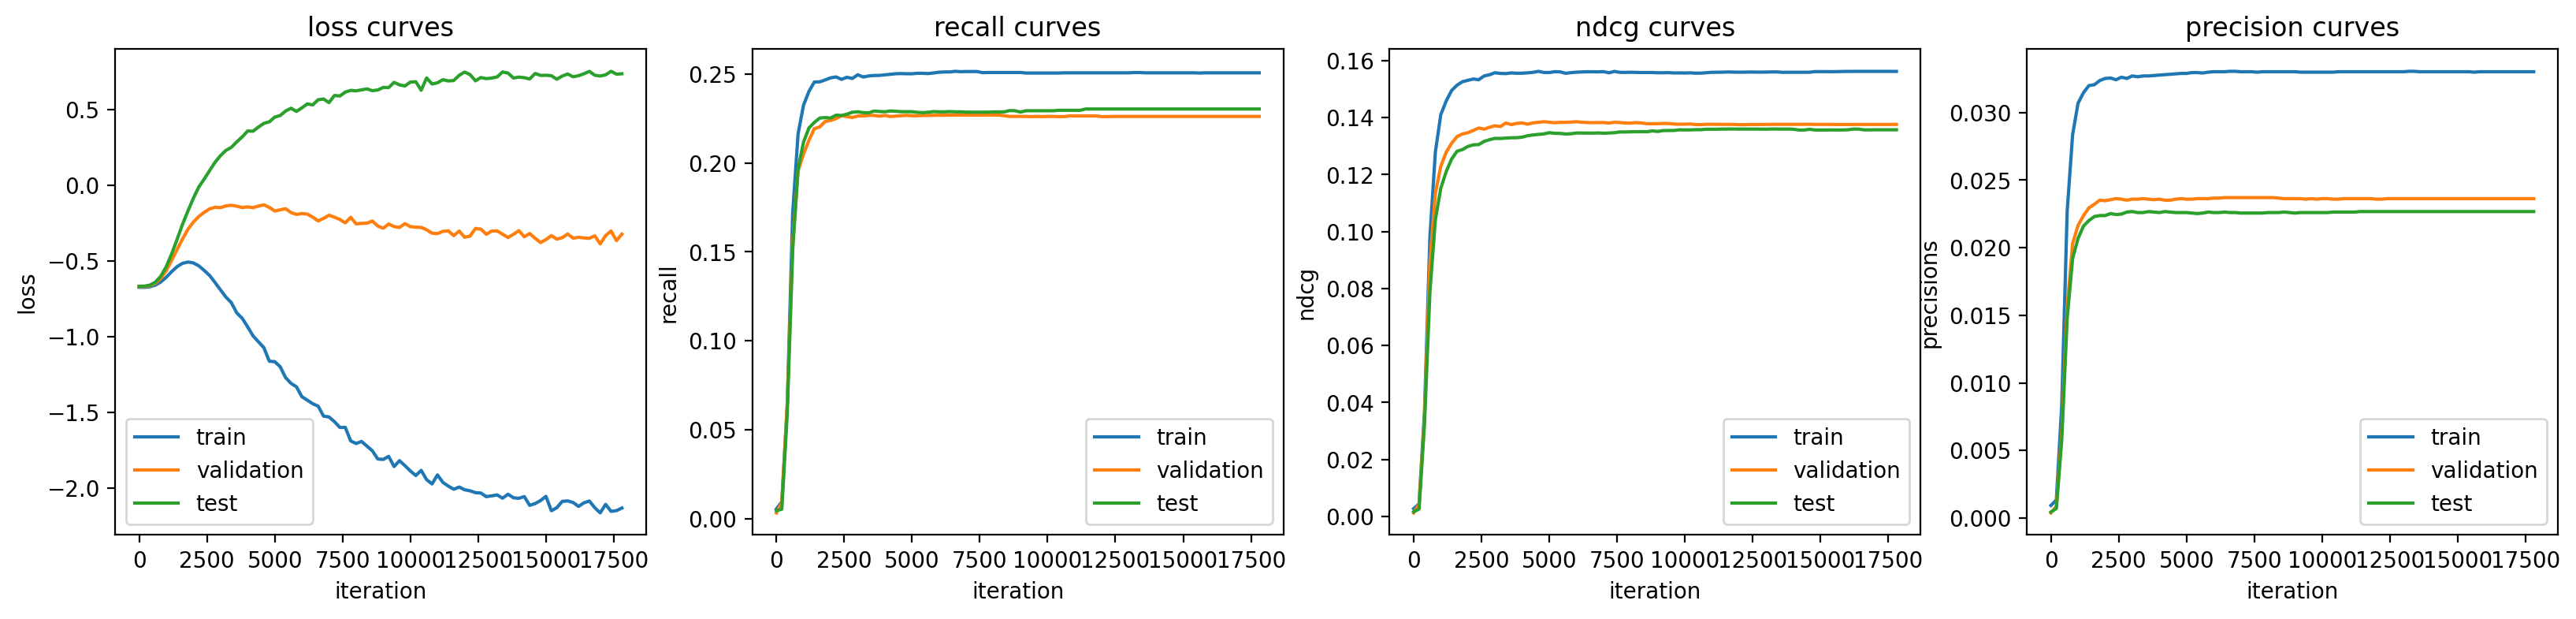

In [21]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=200)

ax[0].plot(iters, train_losses, label='train')
ax[0].plot(iters, val_losses, label='validation')
ax[0].plot(iters, test_losses, label='test')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].set_title('loss curves')
ax[0].legend()

ax[1].plot(iters, train_recalls, label='train')
ax[1].plot(iters, val_recalls, label='validation')
ax[1].plot(iters, test_recalls, label='test')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('recall')
ax[1].set_title('recall curves')
ax[1].legend()

ax[2].plot(iters, train_ndcgs, label='train')
ax[2].plot(iters, val_ndcgs, label='validation')
ax[2].plot(iters, test_ndcgs, label='test')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('ndcg')
ax[2].set_title('ndcg curves')
ax[2].legend()

ax[3].plot(iters, train_precisions, label='train')
ax[3].plot(iters, val_precisions, label='validation')
ax[3].plot(iters, test_precisions, label='test')
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('precisions')
ax[3].set_title('precision curves')
ax[3].legend()

plt.show()

## Evaluation

In [36]:
model.eval()
user_pos_items = get_user_positive_items(edge_index)
id_to_course = {v: k for k, v in courseIds.items()}
user_pos_items[35]

In [48]:
def make_predictions(user, num_recs, only_new=True):
    e_u = model.users_emb_final[user]
    scores = model.items_emb_final @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)
    indices = [index.item() for index in indices]
    
    print(f"Here are classes user {user} has already taken:")
    for index in user_pos_items[user]:
        print(id_to_course[index])
    print()
    
    print(f'Here are the top recommended courses{" (* means already taken)" if not only_new else ""}:')
    i = 0
    not_yet_taken = 0
    while not_yet_taken < num_recs:
        if not only_new or indices[i]+num_users not in user_pos_items[user]:
            print(f"{id_to_course[indices[i]+num_users]} {'(*)' if indices[i]+num_users in user_pos_items[user] else ''}")
        if indices[i]+num_users not in user_pos_items[user]:
            not_yet_taken += 1
        i += 1

In [49]:
USER_ID = 7
NUM_RECS = 5

make_predictions(USER_ID, NUM_RECS)

Here are classes user 7 has already taken:
COLLEGE101
CS106B
CSRE30
HISTORY1
MATH21
UAR101K
CS103
CS107
MATH51
PSYC135
PSYCH21N

Here are the top recommended courses:
CS106A 
COLLEGE102 
CS109 
PSYCH1 
ECON1 
